In [1]:
import os
from os import path
import numpy as np
import random
import copy
import pandas as pd
import ipython_bell

from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from astropy.visualization import make_lupton_rgb
import sys

plt.style.use('dark_background')

In [2]:
#Makes 3 plots per image: source simulation, lens cutout, complete simulation
def make_graphs(name, sim_i, sim_r, sim_g, cutout_i, cutout_r, cutout_g):
    loc = plticker.MultipleLocator(base=3.75)
    fig, (ax1, ax2, ax3) = plt.subplots(figsize=(15, 4), ncols=3)

    rgb = make_lupton_rgb(sim_i, sim_r, sim_g, Q=11., stretch=40.)
    ax1.set_title('Source(s)')
    ax1.xaxis.set_ticklabels([])
    ax1.yaxis.set_ticklabels([])
    #ax1.xaxis.set_major_locator(loc)
    #ax1.yaxis.set_major_locator(loc)
    #ax1.grid(which='major', axis='both', linestyle='-')
    original = ax1.imshow(rgb, aspect='equal')#, vmin=0, vmax = 250)
    #fig.colorbar(original, ax=ax1)

    rgb = make_lupton_rgb(cutout_i, cutout_r, cutout_g, Q=11., stretch=40.)
    ax2.set_title('Lens')
    ax2.xaxis.set_ticklabels([])
    ax2.yaxis.set_ticklabels([])
    #ax2.xaxis.set_major_locator(loc)
    #ax2.yaxis.set_major_locator(loc)
    #ax2.grid(which='major', axis='both', linestyle='-')
    cutout = ax2.imshow(rgb, aspect='equal')
    #fig.colorbar(cutout, ax=ax2)
            
    rgb = make_lupton_rgb(sim_i+cutout_i, sim_r+cutout_r, sim_g+cutout_g, Q=11., stretch=40.)
    ax3.set_title('Complete Simulation')
    ax3.xaxis.set_ticklabels([])
    ax3.yaxis.set_ticklabels([])
    #ax3.xaxis.set_major_locator(loc)
    #ax3.yaxis.set_major_locator(loc)
    #ax3.grid(which='major', axis='both', linestyle='-')
    projection = ax3.imshow(rgb, aspect='equal')
    #fig.colorbar(projection, ax=ax3)
    sub_path = '/Users/jimenagonzalez/research/DSPL/Simulations-Double-Source-Gravitational-Lensing/'
    #plt.savefig(sub_path + 'Data/Sim_complete/Image' + name + '.png', bbox_inches='tight')
    plt.show()

In [3]:
# Writes fit file
def write_fit_file(name, x, datos):
    primary = fits.PrimaryHDU()
    image = fits.ImageHDU(x, name="IMAGE")
    #table = fits.TableHDU(data = datos)
    table = fits.BinTableHDU(data = datos)
    hdu_list = fits.HDUList([primary, image, table])
    hdu_list.writeto('/Users/jimenagonzalez/research/DSPL/Simulations-Double-Source-Gravitational-Lensing/Data/Sim_complete/' + name + '.fits', overwrite=True)

In [4]:
def complete_simulations(m, ids):
    directory_sim = '/Users/jimenagonzalez/research/DSPL/Simulations-Double-Source-Gravitational-Lensing/Data/Sim/'
    directory_cutouts = '/Users/jimenagonzalez/research/DSPL/Simulations-Double-Source-Gravitational-Lensing/Data/lens_cutouts/'
    end_name = ['_g.fits', '_i.fits', '_r.fits']
    x = np.zeros((1,3,46,46)) #Complete Simulations
    n = 0
    for lens_id in ids:
        path_sim_id = directory_sim + str(lens_id)
        if(n >= m):
            break
        #check that the sim id folder exist (if not continue)
        if(os.path.exists(path_sim_id) == False):
            continue
        num_sim_id = int(len(os.listdir(path_sim_id))/3) # num sim with same lens
        #loop on each simulation produced using the same lens
        for j in range(1, num_sim_id+1):
            if(n >= m):
                break
            n += 1 #number of total simulations
            path_cutout = directory_cutouts + str(lens_id) 
            path_sim = path_sim_id + '/' + str(j)
            if(os.path.exists(path_cutout + end_name[0]) == False): 
                continue
            with fits.open(path_cutout + end_name[0]) as hdul: cutout_g = hdul[0].data
            with fits.open(path_cutout + end_name[1]) as hdul: cutout_i = hdul[0].data
            with fits.open(path_cutout + end_name[2]) as hdul: cutout_r = hdul[0].data
            with fits.open(path_sim + end_name[0]) as hdul: sim_g = hdul[0].data
            with fits.open(path_sim + end_name[1]) as hdul: sim_i = hdul[0].data
            with fits.open(path_sim + end_name[2]) as hdul: sim_r = hdul[0].data
            
            ele_sim = np.array([cutout_g + sim_g, cutout_r + sim_r, cutout_i + sim_i])
            ele_sim = np.rot90(ele_sim, k=random.randint(0, 4), axes=(1, 2))
            if(random.randint(0, 1) == 1):
                ele_sim = np.flip(ele_sim, 2)
            x = np.append(x, [ele_sim], axis = 0)
    x = np.delete(x, 0, axis = 0)
    return(x)

In [5]:
#19712 lens cutouts
ids = pd.read_csv('/Users/jimenagonzalez/research/DSPL/Simulations-Double-Source-Gravitational-Lensing/Data/all_data_sim.csv')['COADD_OBJECT_ID'].sample(frac = 1)
x = complete_simulations(202, ids)
print(len(x))

202


In [6]:
#generating table:

datos = np.zeros((1,4))
ele_sim = np.array([1,2,3,4])

for i in range(67):
    datos = np.append(datos, np.ones((1,4)), axis = 0)
    datos = np.append(datos, [ele_sim], axis = 0)  
    datos = np.append(datos, np.zeros((1,4)), axis = 0)

#print(datos)

names = ['a', 'b', 'c', 'd']
datos = Table(data = datos, names = names)
datos

a,b,c,d
float64,float64,float64,float64
0.0,0.0,0.0,0.0
1.0,1.0,1.0,1.0
1.0,2.0,3.0,4.0
0.0,0.0,0.0,0.0
1.0,1.0,1.0,1.0
1.0,2.0,3.0,4.0
0.0,0.0,0.0,0.0
1.0,1.0,1.0,1.0
1.0,2.0,3.0,4.0


In [7]:
name_file = 'other' #'other'

In [8]:
print(x.shape)
write_fit_file(name_file, x, datos)

(202, 3, 46, 46)


In [9]:
filename = '/Users/jimenagonzalez/research/DSPL/Simulations-Double-Source-Gravitational-Lensing/Data/Sim_complete/'
filename = filename + 'other.fits'
hdul = fits.open(filename)
hdul.info()
images = hdul[1].data.astype(np.float32)
datos = hdul[2].data
hdul.close()

Filename: /Users/jimenagonzalez/research/DSPL/Simulations-Double-Source-Gravitational-Lensing/Data/Sim_complete/other.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  IMAGE         1 ImageHDU        10   (46, 46, 3, 202)   float64   
  2                1 BinTableHDU     16   202R x 4C   [D, D, D, D]   


In [10]:
print(images.shape)
l1, l2 = np.zeros(int(len(x)/2), dtype = np.int64), np.ones(int(len(x)/2), dtype = np.int64)
labels = np.concatenate((l1, l2))
print(labels.shape)

(202, 3, 46, 46)
(202,)


In [11]:
print(datos)
df = pd.DataFrame(datos)
print(df.shape)

[(0., 0., 0., 0.) (1., 1., 1., 1.) (1., 2., 3., 4.) (0., 0., 0., 0.)
 (1., 1., 1., 1.) (1., 2., 3., 4.) (0., 0., 0., 0.) (1., 1., 1., 1.)
 (1., 2., 3., 4.) (0., 0., 0., 0.) (1., 1., 1., 1.) (1., 2., 3., 4.)
 (0., 0., 0., 0.) (1., 1., 1., 1.) (1., 2., 3., 4.) (0., 0., 0., 0.)
 (1., 1., 1., 1.) (1., 2., 3., 4.) (0., 0., 0., 0.) (1., 1., 1., 1.)
 (1., 2., 3., 4.) (0., 0., 0., 0.) (1., 1., 1., 1.) (1., 2., 3., 4.)
 (0., 0., 0., 0.) (1., 1., 1., 1.) (1., 2., 3., 4.) (0., 0., 0., 0.)
 (1., 1., 1., 1.) (1., 2., 3., 4.) (0., 0., 0., 0.) (1., 1., 1., 1.)
 (1., 2., 3., 4.) (0., 0., 0., 0.) (1., 1., 1., 1.) (1., 2., 3., 4.)
 (0., 0., 0., 0.) (1., 1., 1., 1.) (1., 2., 3., 4.) (0., 0., 0., 0.)
 (1., 1., 1., 1.) (1., 2., 3., 4.) (0., 0., 0., 0.) (1., 1., 1., 1.)
 (1., 2., 3., 4.) (0., 0., 0., 0.) (1., 1., 1., 1.) (1., 2., 3., 4.)
 (0., 0., 0., 0.) (1., 1., 1., 1.) (1., 2., 3., 4.) (0., 0., 0., 0.)
 (1., 1., 1., 1.) (1., 2., 3., 4.) (0., 0., 0., 0.) (1., 1., 1., 1.)
 (1., 2., 3., 4.) (0., 0., 0., 0.)

In [12]:
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils.multiclass import unique_labels
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [13]:
class ImageDataset(Dataset):
    """Dataset of Images and Labels"""

    def __init__(self, images, labels, transform=None):
        """
        Create a PyTorch dataset from an array of images
		and an array of labels
        """
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.images[idx]
        label = np.array(self.labels[idx])
        
        sample = {'image': image, 'label': label}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [14]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors"""

    def __call__(self, sample):
        image, label = sample['image'], sample['label']
		
		# I like to add any scaling functions here, so uncomment if desired
		#image = (image - np.min(image, axis=(-1,-2))[:,:,np.newaxis,np.newaxis]) / np.max(image - np.min(image, axis=(-1,-2))[:,:,np.newaxis,np.newaxis], axis=(-1,-2))[:,:,np.newaxis,np.newaxis]

        return {'image': torch.from_numpy(image).float(),
                'label': torch.from_numpy(label)}

In [15]:
def make_train_test_datasets(images, data, labels, test_size=0.2, transform=ToTensor()):
    """
	Make training and testing datasets
	
	Args:
	    images: 4D array of all images
        labels: 1D array of the labels for each image
        test_size: the fraction of the images to use as the test dataset
		transform: the PyTorch transformation to apply to the data
		
	Returns
	    train_dataset: An instance of the ImageDataset Class for training
		test_dataset: An instance of the ImageDataset Class for testing
	"""

    # Shuffle and split data
    y = labels
    train_images, test_images, train_labels, test_labels = train_test_split(
        images, labels, test_size=test_size, random_state=8, stratify=y)
    
    train_data, test_data, ttrain_labels, ttest_labels = train_test_split(
        data, labels, test_size=test_size, random_state=8, stratify=y)
    
    print(train_labels)
    print(ttrain_labels)
    
    # Create a PyTorch Dataset
    return (ImageDataset(train_images, train_labels, transform=transform),
            ImageDataset(test_images, test_labels, transform=transform), train_data, test_data)

In [16]:
class CNN(nn.Module):
    """
    Convolutional Neural Network for multiband data. Note that you
    will need to update the number of in_features for self.fc3.
    """
    def __init__(self, in_channels, num_classes):
        """
		Args:
		    in_channels: number of bands (gri = 3, griz=4)
			num_classes: number of unique labels in your dataset
		"""
        super(CNN, self).__init__()
        
        #Network Components
        self.conv1 = nn.Conv2d(in_channels=in_channels, 
                               out_channels=48, 
                               kernel_size=15, 
                               stride=3,
                               padding=2)

        self.conv2 = nn.Conv2d(in_channels=48, 
                               out_channels=96,
                               kernel_size=5, 
                               stride=1,
                               padding=2)
        
        self.dropout1 = nn.Dropout2d(0.25)
        
        self.dropout2 = nn.Dropout2d(0.5)
        
        self.fc1 = nn.Linear(in_features=3456, 
                             out_features=408)

        self.fc2 = nn.Linear(in_features=408, 
                             out_features=25)

        self.fc3 = nn.Linear(in_features=25, 
                             out_features=num_classes)


    def forward(self, x):
        #Network Flow
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)
        return output

    def init_weights(self, m):
        if (type(m) == nn.Linear or type(m) == nn.Conv2d):
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)

In [17]:
def train_cnn(
    cnn, 
    train_dataloader, 
    train_dataset=None,
    test_dataset=None,
    validation_size=None, 
    monitor=False,
    number_of_training_epochs=10,
    learning_rate=0.0001):
	
    """
    Train a CNN and output performance if desired

    Args:
        cnn: an instance of the CNN class
        train_dataloader: a PyTorch DataLoader for the training dataset
        train_dataset: an instance of the ImageDataset class for training
        test_dataset: an instance of the ImageDataset class for testing
        validation_size: the number of images to use for monitoring
            - large numbers will slow down training. ~100 is good.
        monitor: set to True if you want status updates on training
        number_of_training_epochs: number of times to go through the dataset
        learning_rate: multiplicative factor for updating network weights
            - small learning_rate will mean slow training
            - large learning_rate will train fast, but you may miss the best weights
            - ~0.001 is a good starting point
    """
    if not monitor and (train_dataset is None or test_dataset is None):
        raise ValueError("Must pass training and testing datasets for monitoring")
    
    if validation_size is None:
        validation_size=len(test_dataset)
    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)
    
    losses, train_acc, validation_acc = [], [], []

    for epoch in range(number_of_training_epochs):
        sys.stdout.write("\rEpoch {0}\r".format(epoch + 1))
        sys.stdout.flush()

        for i_batch, sample_batched in enumerate(train_dataloader):

            #Clear out all existing gradients on the loss surface to reevaluate for this step
            optimizer.zero_grad()

            #Get the CNN's current prediction of the training data
            output = cnn(sample_batched['image'])

            #Calculate the loss by comparing the prediction to the truth
            loss = loss_function(output, sample_batched['label']) 

            #Evaluate all gradients along the loss surface using back propagation
            loss.backward()

            #Based on the gradients, take the optimal step in the weight space
            optimizer.step()

            #Performance monitoring if desired
            if monitor:
                if i_batch % 200 == 0: #before batch 200
                    train_output = cnn(train_dataset[0:validation_size]['image'])
                    validation_output = cnn(test_dataset[0:validation_size]['image'])

                    train_predictions = torch.max(train_output, 1)[1].data.numpy()
                    validation_predictions = torch.max(validation_output, 1)[1].data.numpy()

                    train_accuracy = np.sum(train_predictions == train_dataset[0:validation_size]['label'].numpy()) / validation_size
                    validation_accuracy = np.sum(validation_predictions == test_dataset[0:validation_size]['label'].numpy()) / validation_size

                    print("Epoch: {0} Batch: {1}  | Training Accuracy: {2:.3f} -- Validation Accuracy: {3:.3f} -- Loss: {4:.3f}".format(epoch + 1, i_batch + 1, train_accuracy, validation_accuracy, loss.data.numpy()))

                    losses.append(loss.data.numpy())
                    train_acc.append(train_accuracy)
                    validation_acc.append(validation_accuracy)
   
    setattr(cnn, 'losses', losses)
    setattr(cnn, 'train_acc', train_acc)
    setattr(cnn, 'validation_acc', validation_acc)

    return cnn

In [18]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title='',
                          cmap=plt.cm.Blues, name = 'generic'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(5,3), dpi=120)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    
    ax.set_xticks(np.arange(cm.shape[1]))
    ax.set_yticks(np.arange(cm.shape[0]))
    ax.set_xticklabels(classes, fontsize=12)
    ax.set_yticklabels(classes, fontsize=12)
    ax.set_xlabel('Predicted Class', fontsize=14)
    ax.set_ylabel('True Class', fontsize=14)

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black", fontsize=12)
    fig.tight_layout()
    plt.show()
    return

In [19]:
def plot_performance(cnn):
    x = np.linspace(1,len(cnn.losses),len(cnn.losses))
    fig, ax1 = plt.subplots(figsize=(12, 7), ncols=1)
    ax1.set_title('Performance')
    ax1.set_xlabel('Epoch')
    ax1.plot(x, cnn.losses, 'wo', label = 'Loss')
    ax1.plot(x, cnn.train_acc, 'ro', label = 'Training Accuracy')
    ax1.plot(x, cnn.validation_acc, 'go', label = 'Validation Accuracy')
    ax1.legend()
    plt.xlim([1.5, len(cnn.losses) + 0.5])
    plt.ylim([0, 2])
    plt.show(block=True)#'Performance_' + name +'.png', bbox_inches='tight')


In [20]:
print(images.shape, datos.shape)
train_dataset, test_dataset, train_data, test_data = make_train_test_datasets(images, datos, labels)

print(test_dataset.labels)

(202, 3, 46, 46) (202,)
[0 0 0 0 0 1 0 0 0 1 1 0 0 1 1 0 1 0 1 0 1 1 1 1 0 0 1 0 1 0 1 1 0 1 0 1 0
 1 0 0 0 0 1 1 0 1 1 1 0 1 1 1 1 1 1 0 1 0 1 0 0 1 0 1 0 0 1 0 1 0 0 0 0 0
 0 0 1 1 0 1 1 1 0 1 0 0 0 1 1 1 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 1 0 0
 1 0 1 1 0 1 1 1 0 1 0 1 1 1 0 1 0 0 0 1 1 1 0 0 0 1 1 0 0 1 1 0 1 0 1 0 1
 0 1 1 1 0 0 1 0 1 1 1 1 1]
[0 0 0 0 0 1 0 0 0 1 1 0 0 1 1 0 1 0 1 0 1 1 1 1 0 0 1 0 1 0 1 1 0 1 0 1 0
 1 0 0 0 0 1 1 0 1 1 1 0 1 1 1 1 1 1 0 1 0 1 0 0 1 0 1 0 0 1 0 1 0 0 0 0 0
 0 0 1 1 0 1 1 1 0 1 0 0 0 1 1 1 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 1 0 0
 1 0 1 1 0 1 1 1 0 1 0 1 1 1 0 1 0 0 0 1 1 1 0 0 0 1 1 0 0 1 1 0 1 0 1 0 1
 0 1 1 1 0 0 1 0 1 1 1 1 1]
[1 0 1 1 0 0 1 1 1 1 1 1 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 1 0 1 1 1
 1 1 0 1]


In [21]:
df = pd.DataFrame(test_data)
df

,a,b,c,d
0,1.0,1.0,1.0,1.0
1,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,1.0
3,0.0,0.0,0.0,0.0
4,1.0,2.0,3.0,4.0
5,1.0,1.0,1.0,1.0
6,0.0,0.0,0.0,0.0
7,1.0,1.0,1.0,1.0
8,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0


In [22]:
# Make a DataLoader to train the network
train_dataloader = DataLoader(train_dataset, batch_size=20, shuffle=True, num_workers=4) # batch_size = 20

# Make a CNN
cnn = CNN(
	in_channels=np.shape(images)[1], 
	num_classes=len(np.unique(labels)))

#Initialize weights
cnn.apply(cnn.init_weights)

CNN(
  (conv1): Conv2d(3, 48, kernel_size=(15, 15), stride=(3, 3), padding=(2, 2))
  (conv2): Conv2d(48, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=3456, out_features=408, bias=True)
  (fc2): Linear(in_features=408, out_features=25, bias=True)
  (fc3): Linear(in_features=25, out_features=2, bias=True)
)

In [23]:
# Train the CNN
cnn = train_cnn(cnn, 
				train_dataloader, 
				train_dataset=train_dataset,
				test_dataset=test_dataset,
				validation_size=200, #100
				number_of_training_epochs=10, #150
				monitor=True)

Epoch: 1 Batch: 1  | Training Accuracy: 0.395 -- Validation Accuracy: 0.105 -- Loss: 19.455
Epoch: 2 Batch: 1  | Training Accuracy: 0.430 -- Validation Accuracy: 0.105 -- Loss: 4.477
Epoch: 3 Batch: 1  | Training Accuracy: 0.425 -- Validation Accuracy: 0.110 -- Loss: 4.767
Epoch: 4 Batch: 1  | Training Accuracy: 0.430 -- Validation Accuracy: 0.110 -- Loss: 4.032
Epoch: 5 Batch: 1  | Training Accuracy: 0.465 -- Validation Accuracy: 0.100 -- Loss: 3.163
Epoch: 6 Batch: 1  | Training Accuracy: 0.380 -- Validation Accuracy: 0.095 -- Loss: 5.449
Epoch: 7 Batch: 1  | Training Accuracy: 0.410 -- Validation Accuracy: 0.085 -- Loss: 3.142
Epoch: 8 Batch: 1  | Training Accuracy: 0.430 -- Validation Accuracy: 0.070 -- Loss: 3.924
Epoch: 9 Batch: 1  | Training Accuracy: 0.440 -- Validation Accuracy: 0.085 -- Loss: 3.490
Epoch: 10 Batch: 1  | Training Accuracy: 0.460 -- Validation Accuracy: 0.075 -- Loss: 1.642


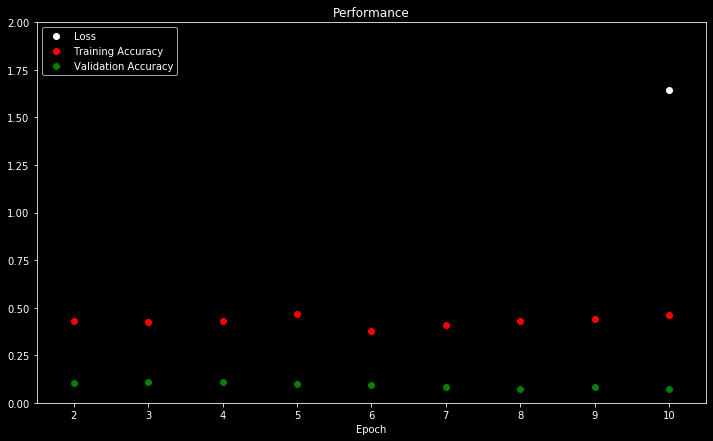

In [24]:
plot_performance(cnn)

In [25]:
# Use the CNN to classify your whole test dataset
cnn.eval()

non_binary_predictions = cnn(test_dataset[:]['image'])

test_predictions = torch.max(cnn(test_dataset[:]['image']), 1)[1].data.numpy()  
test_labels = test_dataset[:]['label'].data.numpy()

In [26]:
# I have test_predictions, test_labels, test_dataset and test_data (df)
print(test_predictions)
print(test_labels)
print(test_dataset.images.shape)
print(df)

[0 1 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 1 1 0 0 1 0 0 1 0 0 1 1 0 1 0 1 0 0 0 0
 1 0 0 0]
[1 0 1 1 0 0 1 1 1 1 1 1 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 1 0 1 1 1
 1 1 0 1]
(41, 3, 46, 46)
      a    b    c    d
0   1.0  1.0  1.0  1.0
1   0.0  0.0  0.0  0.0
2   1.0  1.0  1.0  1.0
3   0.0  0.0  0.0  0.0
4   1.0  2.0  3.0  4.0
5   1.0  1.0  1.0  1.0
6   0.0  0.0  0.0  0.0
7   1.0  1.0  1.0  1.0
8   0.0  0.0  0.0  0.0
9   0.0  0.0  0.0  0.0
10  1.0  2.0  3.0  4.0
11  1.0  2.0  3.0  4.0
12  1.0  1.0  1.0  1.0
13  1.0  1.0  1.0  1.0
14  1.0  2.0  3.0  4.0
15  1.0  2.0  3.0  4.0
16  0.0  0.0  0.0  0.0
17  1.0  2.0  3.0  4.0
18  0.0  0.0  0.0  0.0
19  0.0  0.0  0.0  0.0
20  1.0  1.0  1.0  1.0
21  1.0  2.0  3.0  4.0
22  1.0  1.0  1.0  1.0
23  1.0  2.0  3.0  4.0
24  1.0  1.0  1.0  1.0
25  0.0  0.0  0.0  0.0
26  1.0  2.0  3.0  4.0
27  0.0  0.0  0.0  0.0
28  0.0  0.0  0.0  0.0
29  0.0  0.0  0.0  0.0
30  1.0  2.0  3.0  4.0
31  0.0  0.0  0.0  0.0
32  1.0  2.0  3.0  4.0
33  0.0  0.0  0.0  0.0
34  1.0  

In [27]:
#get indices of test dataset where the label is wrong predicted
indices = []
for i in range(len(test_labels)):
    if(test_predictions[i] != test_labels[i]):
        indices.append(i)

In [28]:
print(indices)

[0, 1, 2, 3, 4, 6, 7, 8, 10, 12, 14, 17, 18, 21, 27, 29, 30, 34, 35, 36, 38, 40]


In [29]:
test_data[indices]

FITS_rec([(1., 1., 1., 1.), (0., 0., 0., 0.), (1., 1., 1., 1.),
          (0., 0., 0., 0.), (1., 2., 3., 4.), (0., 0., 0., 0.),
          (1., 1., 1., 1.), (0., 0., 0., 0.), (1., 2., 3., 4.),
          (1., 1., 1., 1.), (1., 2., 3., 4.), (1., 2., 3., 4.),
          (0., 0., 0., 0.), (1., 2., 3., 4.), (0., 0., 0., 0.),
          (0., 0., 0., 0.), (1., 2., 3., 4.), (1., 1., 1., 1.),
          (0., 0., 0., 0.), (1., 2., 3., 4.), (0., 0., 0., 0.),
          (0., 0., 0., 0.)],
         dtype=(numpy.record, [('a', '>f8'), ('b', '>f8'), ('c', '>f8'), ('d', '>f8')]))

In [30]:
df

,a,b,c,d
0,1.0,1.0,1.0,1.0
1,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,1.0
3,0.0,0.0,0.0,0.0
4,1.0,2.0,3.0,4.0
5,1.0,1.0,1.0,1.0
6,0.0,0.0,0.0,0.0
7,1.0,1.0,1.0,1.0
8,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0


In [31]:
df.loc[0, : ]
#df.iloc[['1', '0'], : ]
#dfObj.iloc[[2 ,0 ] , : ]

a    1.0
b    1.0
c    1.0
d    1.0
Name: 0, dtype: float64

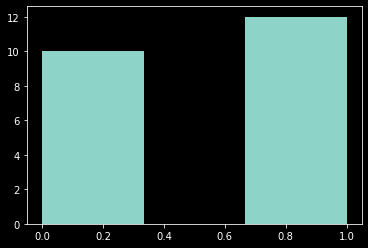

In [32]:
wpredic = test_data[indices] #sample in test wrong predicted
wpredic['a']

plt.figure()
plt.hist(wpredic['a'], 3)
plt.show()
#incluso puedo hacer una grafica de prediccion no binaria vs valor parametro

[0.71310806 0.09422374 0.5125792  0.5176673  0.48011842 0.53920424
 0.75553733 0.62694067 0.7660998  0.4597451  0.6020204  0.06431361
 0.72693837 0.56002426 0.55130684 0.64675933 0.60977316 0.45543832
 0.49453038 0.521461   0.5453838  0.4949685  0.6286184  0.6508484
 0.4410556  0.54774624 0.5108703  0.4654329  0.4998653  0.5425206
 0.48711157 0.5842826  0.1419606  0.62752414 0.7988455  0.51889765
 0.5805328  0.4324627  0.53300667 0.74872106 0.9941308 ]
[0.28689197 0.90577626 0.48742074 0.4823327  0.5198816  0.46079576
 0.24446265 0.37305936 0.23390025 0.5402549  0.39797962 0.93568635
 0.2730616  0.43997574 0.4486932  0.35324073 0.39022684 0.5445617
 0.50546956 0.47853902 0.45461625 0.5050315  0.37138158 0.34915155
 0.5589444  0.4522538  0.48912975 0.5345671  0.5001347  0.4574794
 0.5128885  0.41571742 0.8580394  0.37247586 0.20115454 0.48110235
 0.41946718 0.5675373  0.46699336 0.25127888 0.00586914]
[1.         1.         0.99999994 1.         1.         1.
 1.         1.         1.  

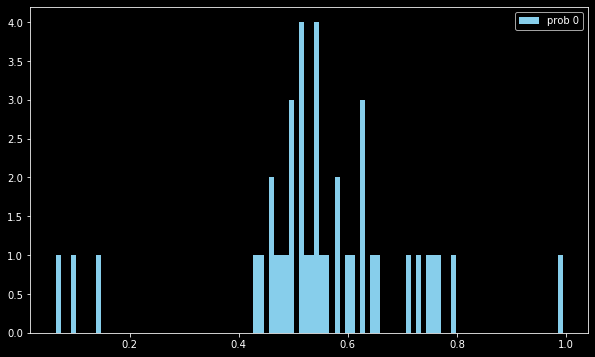

In [40]:
non_binary_predictions = cnn(test_dataset[:]['image'])
m = nn.Softmax(dim=1) 
prob = (m(non_binary_predictions))
print(prob[:,0].detach().numpy())
print(prob[:,1].detach().numpy())
print(prob[:,1].detach().numpy() + prob[:,0].detach().numpy())
prob = prob[:,0].detach().numpy()
#print(prob)
plt.style.use('dark_background')
plt.figure(figsize=(10,6))
plt.hist(prob, 100, color = "skyblue", label = 'prob 0')
#plt.hist(y, 100, color = "pink", label = '1')
plt.legend()
plt.show()

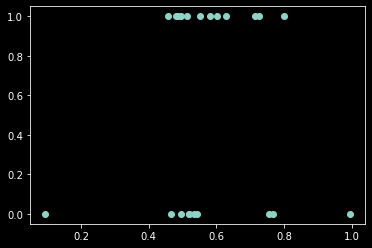

In [34]:
plt.figure()
plt.plot(prob[indices], wpredic['a'], 'o')
plt.show()